<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/reach_landuse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Carli Beisel

September 16, 2024

Purpose: Identify urban proportion and crop type in each reach within Mason

## Urbanization

In [63]:
# ------------------ #
#  Import Libraries  #
# ------------------ #
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
! pip install rasterio
import rasterio
import rasterio.features
from rasterio.mask import mask
from rasterio import mask
from rasterio.crs import CRS
import glob
import os
import json

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# --------------- #
#   Load Files    #
# --------------- #

reaches = gpd.read_file('/content/drive/MyDrive/Data/Mason/data_input/reach_shapefile/Reach_Final/Reach_Final.shp')

#cdl
cdl = rasterio.open('/content/drive/MyDrive/Data/Mason/data_input/land_cover/mason_cdl/mason2023.tif')

# FWT shapefile of irrigation type based on ML, satellite imagery, & OpenET
irrigation_type = gpd.read_file('/content/drive/MyDrive/Data/Mason/data_input/fwt_irrigation_runoff/mason_creek_fields/mason_creek_fields.shp')

In [44]:
# --------------- #
# Area of each reach
# --------------- #

# Calculate the area in square meters (or square feet depending on the CRS)
reaches['area'] = reaches.geometry.area
reach_areas = reaches[['Name', 'area']]
print(reach_areas)
reaches['area_km2'] = reaches['area'] / 1_000_000

# Display the reach ID and corresponding area in square kilometers
reach_areas_km2 = reaches[['Name', 'area_km2']]
print(reach_areas_km2)

# Convert area to square miles
reaches['area_mi2'] = reaches['area'] / 2_589_988.11
reach_areas_mi2 = reaches[['Name', 'area_mi2']]
print(reach_areas_mi2)

            Name      area
0    Noble Drain  0.001078
1        Reach 1  0.000791
2   Purdum Reach  0.000490
3  Solomon Reach  0.000388
4        Reach 2  0.000335
5        Reach 3  0.001411
6        Reach 4  0.000228
            Name      area_km2
0    Noble Drain  1.077654e-09
1        Reach 1  7.905772e-10
2   Purdum Reach  4.896739e-10
3  Solomon Reach  3.879509e-10
4        Reach 2  3.349452e-10
5        Reach 3  1.411197e-09
6        Reach 4  2.284644e-10
            Name      area_mi2
0    Noble Drain  4.160846e-10
1        Reach 1  3.052435e-10
2   Purdum Reach  1.890642e-10
3  Solomon Reach  1.497887e-10
4        Reach 2  1.293230e-10
5        Reach 3  5.448661e-10
6        Reach 4  8.821062e-11


<ipython-input-44-244406496c44>:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  reaches['area'] = reaches.geometry.area


In [59]:
## ------------------------------ ##
##  Mask CDL Layer to Each Reach  ##
## ------------------------------ ##

shp_file = gpd.read_file('/content/drive/MyDrive/Data/Mason/data_input/reach_shapefile/Reach_Final/Reach_Final.shp')
cdl = rasterio.open('/content/drive/MyDrive/Data/Mason/data_input/land_cover/mason_cdl/mason2023.tif')
output_dir = '/content/drive/MyDrive/Data/Mason/data_input/land_cover/masked'


shp = shp_file.to_crs(cdl.crs) # shapefile is in the same CRS as the raster

# Loop through each geometry in the shapefile and crop the raster
for i, row in shp.iterrows():
    geometry = row['geometry']
    coords = [json.loads(gpd.GeoSeries(geometry).to_json())['features'][0]['geometry']]
    out_img, out_transform = mask(dataset=cdl, shapes=coords, crop=True, nodata=0)
    out_meta = cdl.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_img.shape[1],
        "width": out_img.shape[2],
        "transform": out_transform
    })

    feature_name = row['Name'] # Name category is reach
    out_filename = os.path.join(output_dir, f'{feature_name}.tif')
    with rasterio.open(out_filename, 'w', **out_meta) as out_tiff:
        out_tiff.write(np.squeeze(out_img, 0), 1)

    print(f'Cropped raster saved to {out_filename}')

TypeError: 'numpy.ndarray' object is not callable

In [88]:
# ---------------------------- #
#    Characterization: Urban
# ---------------------------- #

masked_cdl_dir = '/content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/'

# characterize urban land from cdl data
developed_crop_types = {
    82,   # developed
    121,  # openspace
    122,  # low intensity
    123,  # med intensity
    124,  # high intensity
    62,   # pasture
    176   # pasture
}

SQM_TO_SQMI = 2_589_988.11 # conversion from square meters to square miles
data = []
masked_files = glob.glob(os.path.join(masked_cdl_dir, '*.tif'))
for file_path in masked_files: # loop through each reach
    reach_name = os.path.basename(file_path).replace('.tif', '')  # extract reach name from the file name
    print(f'Processing file for reach: {reach_name}')
    with rasterio.open(file_path) as src:
        cdl_data = src.read(1)
        pixel_width = src.transform[0]   # Pixel width
        pixel_height = -src.transform[4] # Pixel height
        pixel_area = pixel_width * pixel_height  # Area of one pixel in square meters
        unique_crop_types, pixel_counts = np.unique(cdl_data, return_counts=True)

        # Initialize pixel counts
        total_pixels = 0
        developed_pixels = 0
        high_intensity_pixels = 0
        medium_intensity_pixels = 0
        low_intensity_pixels = 0
        open_space_pixels = 0
        pasture_pixels = 0

        # count pixels for each urbanization type
        for crop_type, count in zip(unique_crop_types, pixel_counts):
            total_pixels += count  # Count total number of pixels
            if crop_type in developed_crop_types:
                developed_pixels += count  # Count developed land pixels
                if crop_type == 124:  # High intensity
                    high_intensity_pixels += count
                elif crop_type == 123:  # Medium intensity
                    medium_intensity_pixels += count
                elif crop_type == 122:  # Low intensity
                    low_intensity_pixels += count
                elif crop_type == 121:  # Open space
                    open_space_pixels += count
                elif crop_type == 62: #pasture
                    pasture_pixels += count
                elif crop_type == 176: #pasture/grassland
                    pasture_pixels += count

        # Calculate areas in square meters
        total_area_m2 = total_pixels * pixel_area
        developed_area_m2 = developed_pixels * pixel_area
        high_intensity_area_m2 = high_intensity_pixels * pixel_area
        medium_intensity_area_m2 = medium_intensity_pixels * pixel_area
        low_intensity_area_m2 = low_intensity_pixels * pixel_area
        open_space_area_m2 = open_space_pixels * pixel_area
        pasture_area_m2 = pasture_pixels * pixel_area

        # Convert areas to square miles
        total_area_mi2 = total_area_m2 / SQM_TO_SQMI
        developed_area_mi2 = developed_area_m2 / SQM_TO_SQMI
        high_intensity_area_mi2 = high_intensity_area_m2 / SQM_TO_SQMI
        medium_intensity_area_mi2 = medium_intensity_area_m2 / SQM_TO_SQMI
        low_intensity_area_mi2 = low_intensity_area_m2 / SQM_TO_SQMI
        open_space_area_mi2 = open_space_area_m2 / SQM_TO_SQMI
        pasture_area_mi2 = pasture_area_m2 / SQM_TO_SQMI

        # Calculate proportion of developed land
        if total_area_mi2 > 0:
            percent_developed = 100 * (developed_area_mi2 / total_area_mi2)
        else:
            percent_developed = 0

        # Append the data for this reach
        data.append({
            'Reach': reach_name,
            'Area of Reach (mi²)': total_area_mi2,
            'Urban Land Cover Area (mi²)': developed_area_mi2,
            'High Intensity Urban (mi²)': high_intensity_area_mi2,
            'Medium Intensity Urban (mi²)': medium_intensity_area_mi2,
            'Low Intensity Urban (mi²)': low_intensity_area_mi2,
            'Open Space Urban (mi²)': open_space_area_mi2,
            'Percent of Urban Land': percent_developed,
            'Pasture (mi²)': pasture_area_mi2
        })

urban = pd.DataFrame(data)
urban

Processing file for reach: Noble Drain
Processing file for reach: Reach 1
Processing file for reach: Purdum Reach
Processing file for reach: Solomon Reach
Processing file for reach: Reach 2
Processing file for reach: Reach 3
Processing file for reach: Reach 4


,Reach,Area of Reach (mi²),Urban Land Cover Area (mi²),High Intensity Urban (mi²),Medium Intensity Urban (mi²),Low Intensity Urban (mi²),Open Space Urban (mi²),Percent of Urban Land,Pasture (mi²)
0,Noble Drain,14.667635,1.926843,0.149769,0.320735,0.432280,0.511161,13.136697,0.512898
1,Reach 1,5.863927,2.420281,0.195985,0.563632,0.777687,0.735988,41.274074,0.146989
2,Purdum Reach,6.222886,1.177650,0.007297,0.089653,0.316565,0.410040,18.924503,0.354094
3,Solomon Reach,3.277544,0.841625,0.008687,0.102858,0.245329,0.284596,25.678541,0.200155
4,Reach 2,2.749356,0.562242,0.000695,0.031274,0.126140,0.211623,20.449949,0.192511
5,Reach 3,14.142922,1.182515,0.029537,0.093823,0.139692,0.342280,8.361179,0.577184
6,Reach 4,1.966109,0.217182,0.000000,0.001390,0.021197,0.062896,11.046306,0.131699


## Irrigation Type


In [73]:
# ------------------ #
#  Import Libraries  #
# ------------------ #
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
# --------------- #
#   Load Files    #
# --------------- #
reaches = gpd.read_file('/content/drive/MyDrive/Data/Mason/data_input/reach_shapefile/Reach_Final/Reach_Final.shp')
# FWT shapefile of irrigation type based on ML, satellite imagery, & OpenET
irrigation_type = gpd.read_file('/content/drive/MyDrive/Data/Mason/data_input/fwt_irrigation_runoff/mason_creek_fields/mason_creek_fields.shp')

In [98]:
# ----------------------------------- #
#   Irrigation Type for each Reach    #
# ----------------------------------- #
irrigation_type = irrigation_type.to_crs(reaches.crs)
intersection = gpd.overlay(reaches, irrigation_type, how='intersection')

intersection['area_m2'] = intersection.geometry.area # Calculate the area of each intersected polygon in square meters


SQM_TO_SQMI = 2_589_988.11 # convert the area to square miles
intersection['area_mi2'] = intersection['area_m2'] / SQM_TO_SQMI

# group by reach and irrigation type to calculate the total area of each irrigation type per reach
irrigation_areas_by_reach = intersection.groupby(['Name', 'irr_type'])['area_mi2'].sum().reset_index()

# irrigation type areas for each reach
irrig_type = irrigation_areas_by_reach.pivot(index='Name', columns='irr_type', values='area_mi2').fillna(0)
irrig_type['Total Irrigated Area (mi²)'] = irrig_type.sum(axis=1)
irrig_type = irrig_type.reset_index()
irrig_type = irrig_type.rename(columns={'Name': 'Reach'})

irrig_type

<ipython-input-98-d6617e05b34d>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersection['area_m2'] = intersection.geometry.area # Calculate the area of each intersected polygon in square meters


irr_type,Reach,Flood,Not Irrigated,Sprinkler,Total Irrigated Area (mi²)
0,Noble Drain,1.058882e-10,5.524247e-12,1.921258e-11,1.306250e-10
1,Purdum Reach,4.507588e-11,0.000000e+00,0.000000e+00,4.507588e-11
2,Reach 1,7.986215e-12,2.360060e-12,7.134123e-12,1.748040e-11
3,Reach 2,5.052858e-11,1.087454e-12,0.000000e+00,5.161604e-11
4,Reach 3,3.494073e-10,2.144274e-12,2.153641e-12,3.537052e-10
5,Reach 4,4.963315e-11,1.386733e-12,1.059061e-12,5.207895e-11
6,Solomon Reach,2.531382e-11,1.920244e-12,3.021328e-12,3.025540e-11


## Stacked Bar Plot of Urban + Irrig Type for Each Reach

In [99]:
# -------------------------- #
## Combine Data & Load File
# -------------------------- #

# Combine the two data frame
land_use = pd.merge(urban, irrig_type, on='Reach', how='left')
land_use.to_csv('/content/drive/MyDrive/Data/Mason/data_output/land_use/land_use.csv', index=False)

file = pd.read_csv('/content/drive/MyDrive/Data/Mason/data_output/land_use/land_use.csv')

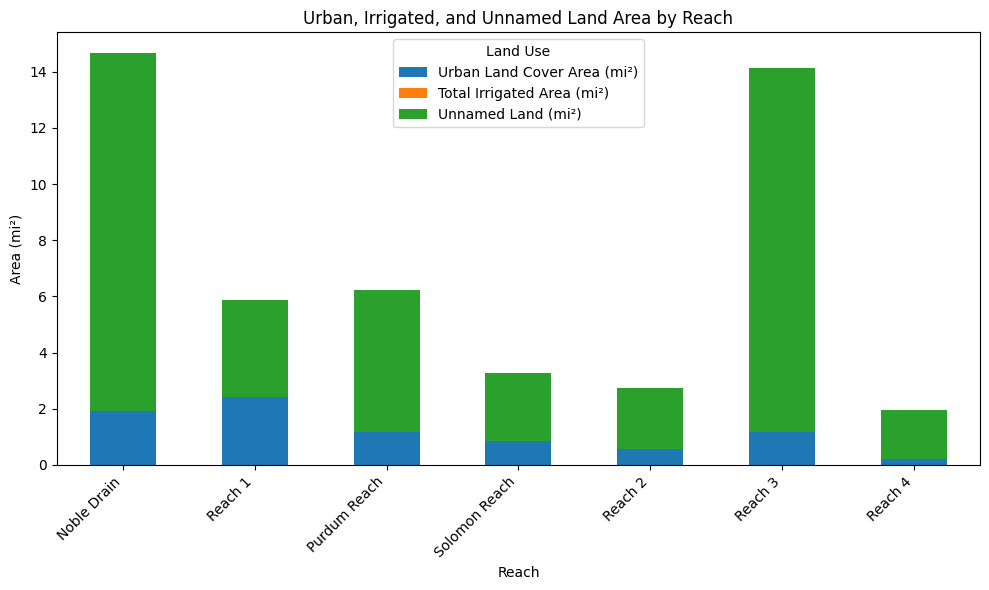

In [100]:
file['Unnamed Land (mi²)'] = file['Area of Reach (mi²)'] - (
    file['Urban Land Cover Area (mi²)'] + file['Total Irrigated Area (mi²)'])

# Fill any negative residuals with 0 (in case of floating-point errors or edge cases)
file['Unnamed Land (mi²)'] = file['Unnamed Land (mi²)'].clip(lower=0)

# Set Reach as the index for easy plotting
file.set_index('Reach', inplace=True)

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Create the stacked bar chart with urban, irrigated, and unnamed land
file[['Urban Land Cover Area (mi²)', 'Total Irrigated Area (mi²)', 'Unnamed Land (mi²)']].plot(
    kind='bar', stacked=True, ax=ax)

# Set plot labels and title
ax.set_xlabel('Reach')
ax.set_ylabel('Area (mi²)')
ax.set_title('Urban, Irrigated, and Unnamed Land Area by Reach')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the legend and plot
plt.legend(title="Land Use")
plt.tight_layout()

# Show the plot
plt.show()

## Crop Type for Each Reach

In [1]:
# ------------------ #
#  Import Libraries  #
# ------------------ #
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
! pip install rasterio
import rasterio
import rasterio.features
from rasterio.mask import mask
from rasterio import mask
from rasterio.crs import CRS
import glob
import json
import os
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 32.7 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# ---------------------------- #
#   Mask to Reach Shapefile    #
# ---------------------------- #

reaches = gpd.read_file('/content/drive/MyDrive/Data/Mason/data_input/reach_shapefile/MasonReaches/MasonReaches.shp')
years = list(range(2014, 2024))
cdl_files = [f'/content/drive/MyDrive/Data/Mason/data_input/land_cover/mason_cdl/mason{year}.tif' for year in years]

# Output directory
output_dir = '/content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Open CDL files and reproject shapefile to match raster CRS
data = [rasterio.open(file) for file in cdl_files]
reaches = reaches.to_crs(data[0].crs)  # Reproject reach shapefile to match raster CRS

# Loop through each reach and each year of CDL data
for i, row in reaches.iterrows():
    feature_name = row['Name']  # Reach name
    geometry = row['geometry']  # Reach geometry
    coords = [json.loads(gpd.GeoSeries(geometry).to_json())['features'][0]['geometry']]  # Geometry in JSON format

    for dataset in data:
        # Extract the last 4 digits before the ".tif" extension to get the year
        year_out = dataset.name[-8:-4]  # This extracts "2014" from "mason2014.tif"

        # Perform the masking operation
        out_img, out_transform = rio_mask(dataset=dataset, shapes=coords, crop=True, nodata=0)  # Use 'rio_mask'
        out_meta = dataset.meta.copy()  # Copy metadata
        out_meta.update({
            "driver": "GTiff",
            "height": out_img.shape[1],
            "width": out_img.shape[2],
            "transform": out_transform
        })

        # Construct output filename using reach name and year in the format '{name}_{year}.tif'
        out_filename = os.path.join(output_dir, f'{feature_name}_{year_out}.tif')

        # Save the masked raster
        with rasterio.open(out_filename, 'w', **out_meta) as out_tiff:
            out_tiff.write(np.squeeze(out_img, 0), 1)

        print(f'Cropped raster for {feature_name} in {year_out} saved to {out_filename}')



Cropped raster for Reach 4 in 2014 saved to /content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/Reach 4_2014.tif
Cropped raster for Reach 4 in 2015 saved to /content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/Reach 4_2015.tif
Cropped raster for Reach 4 in 2016 saved to /content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/Reach 4_2016.tif
Cropped raster for Reach 4 in 2017 saved to /content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/Reach 4_2017.tif
Cropped raster for Reach 4 in 2018 saved to /content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/Reach 4_2018.tif
Cropped raster for Reach 4 in 2019 saved to /content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/Reach 4_2019.tif
Cropped raster for Reach 4 in 2020 saved to /content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/Reach 4_2020.tif
Cropped raster for Reach 4 in 2021 saved to /content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/Reach 4_2021.tif
Cropped 

In [ ]:

## ---------------------- ##
#    Classify Crop Types
## ---------------------- ##

# creates a dictionary that equates numerical code to specific crop types
cdl_categories = {
   36: 'Alfalfa/Hay',
   37: 'Alfalfa/Hay',
   68: 'Apples',
   21: 'Barley',
   1: 'Corn',
   13: 'Corn',
   12: 'Corn',
   82: 'Developed', #developed #####added
   121: 'Developed', #openspace
   122: 'Developed', #low intensity
   123: 'Developed', #med intensity
   124: 'Developed', #high intensity
   61: 'Fallow',
   242: 'Fruit',
   55: 'Fruit',
   209: 'Fruit',
   250: 'Fruit',
   48: 'Fruit',
   223: 'Fruit',
   66: 'Fruit',
   69: 'Fruit',
   218: 'Fruit',
   211: 'Fruit',
   67: 'Fruit',
   77: 'Fruit',
   220: 'Fruit',
   54: 'Fruit',
   221: 'Fruit',
   176: 'Grass/Pasture',
   60: 'Grass/Pasture',
   57: 'Herbs',
   14: 'Herbs',
   51: 'Legumes',
   42: 'Legumes',
   52: 'Legumes',
   5: 'Legumes',
   131: 'NonAg', #barren
   141: 'NonAg', #deciduous forsest
   142: 'NonAg', #evergreen forest
   195: 'NonAg', #herbaceous wetlands
   143: 'NonAg', #mixed forest
   111: 'NonAg', #open water
   112: 'NonAg', #perennial ice/snow
   152: 'NonAg', #shrubland
   190: 'NonAg',
   75: 'Nuts',
   204: 'Nuts',
   76: 'Nuts',
   38: 'Oil Seed',
   31: 'Oil Seed',
   32: 'Oil Seed',
   34: 'Oil Seed',
   6: 'Oil Seed',
   58: 'Other', #clover/wildflowers
   2: 'Other', #cotton
   237: 'Double Crop', #dbl crop barley/shorgum
   226: 'Double Crop', #dbl crop oats/corn
   225: 'Double Crop', #dbl crop winwht/corn
   236: 'Double Crop', #dbl crop durum wht/ shorgum
   56: 'Hops',
   29: 'Other', #millet
   35: 'Other', #mustard
   28: 'Other', #oats
   44: 'Other', #other crops
   25: 'Other', #other small grains
   3: 'Other', #rice
   27: 'Other', #rye
   33: 'Other', #safflower
   59: 'Other', #sod/grass seed
   4: 'Other', #shorgum
   30: 'Other',
   11: 'Other', #tobacco
   205: 'Other', #triticale
   224: 'Other', #vetch
   43: 'Potatoes',
   41: 'Sugarbeets',
   70: 'Trees',
   71: 'Trees',
   207: 'Vegetables',
   214: 'Vegetables',
   243: 'Vegetables',
   206: 'Vegetables',
   244: 'Vegetables',
   50: 'Vegetables',
   208: 'Vegetables',
   249: 'Vegetables',
   219: 'Vegetables',
   227: 'Vegetables',
   47: 'Vegetables',
   49: 'Onions',
   53: 'Vegetables',
   216: 'Vegetables',
   229: 'Vegetables',
   246: 'Vegetables',
   222: 'Vegetables',
   46: 'Vegetables',
   247: 'Vegetables',
   39: 'Wheat',
   22: 'Wheat',
   23: 'Wheat',
   24: 'Wheat'
}

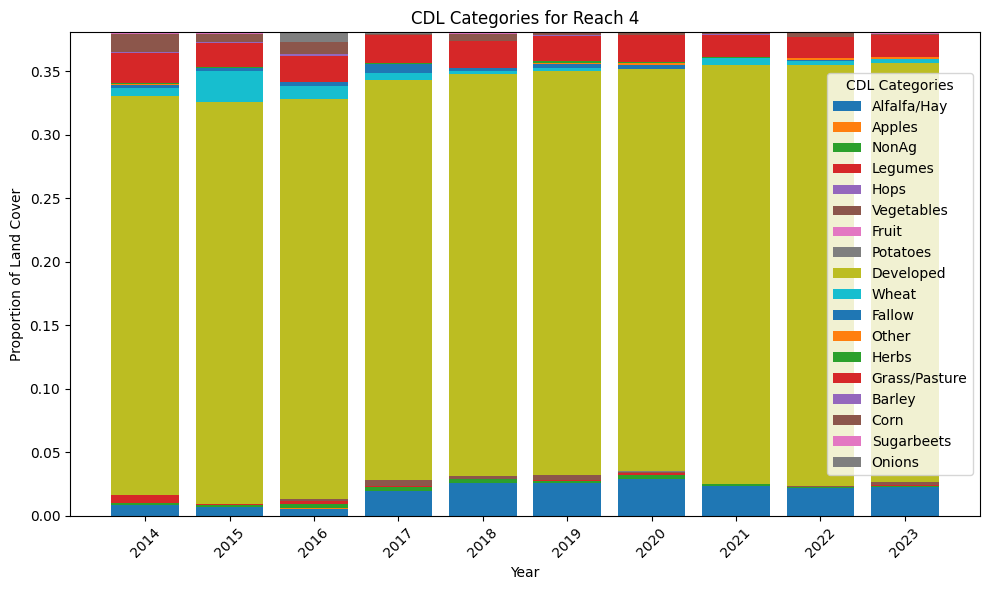

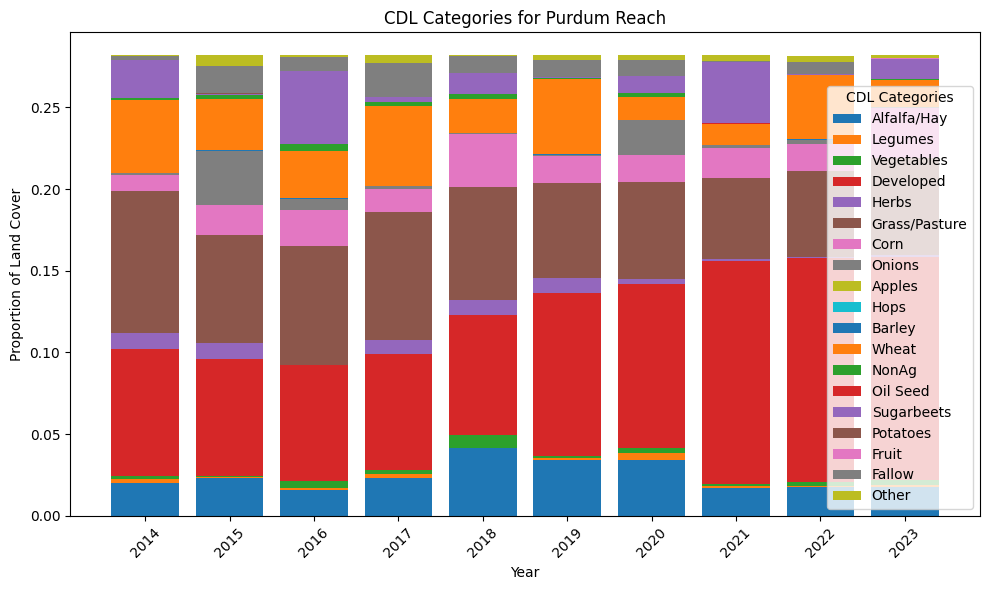

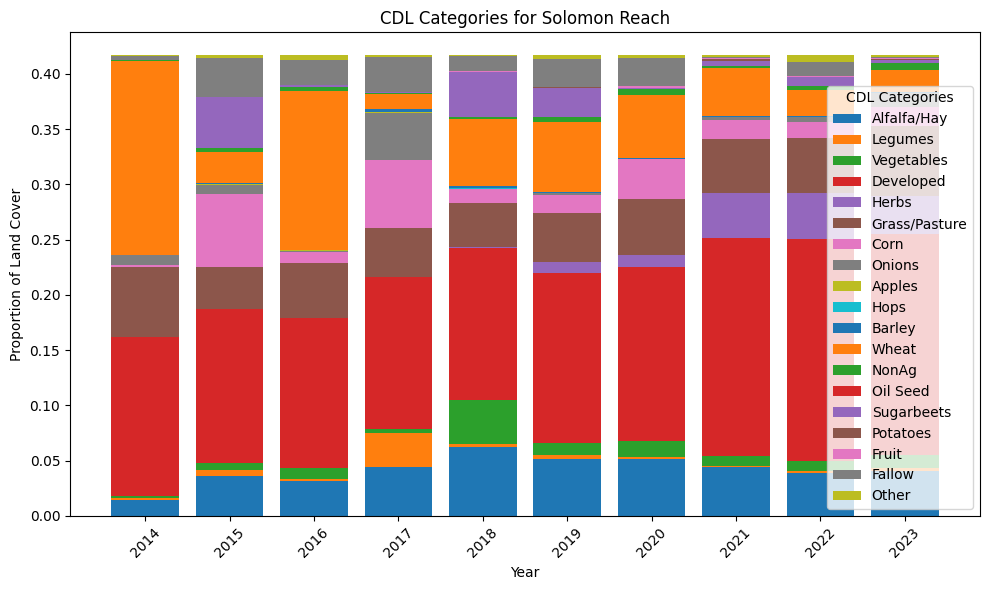

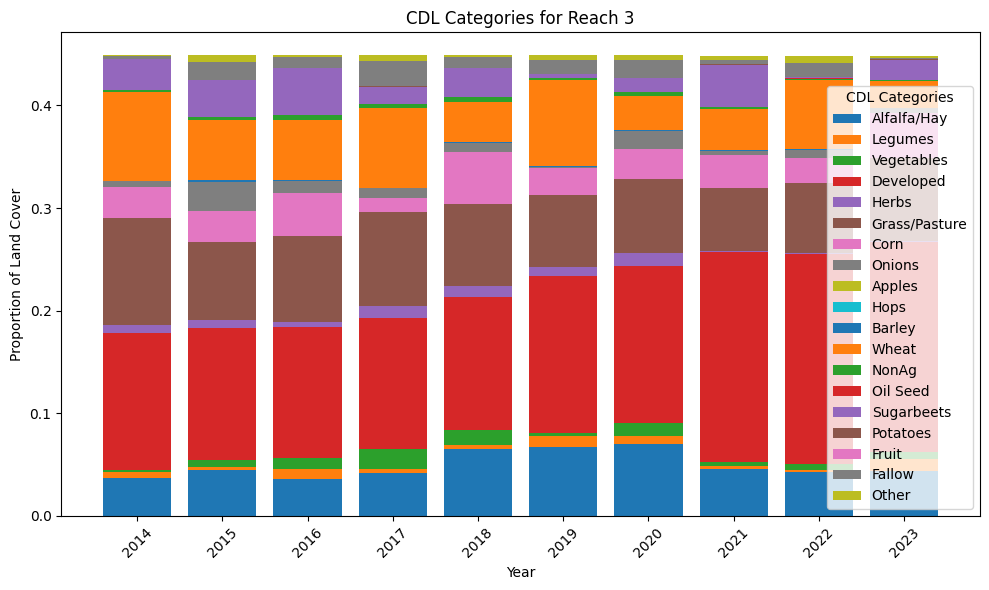

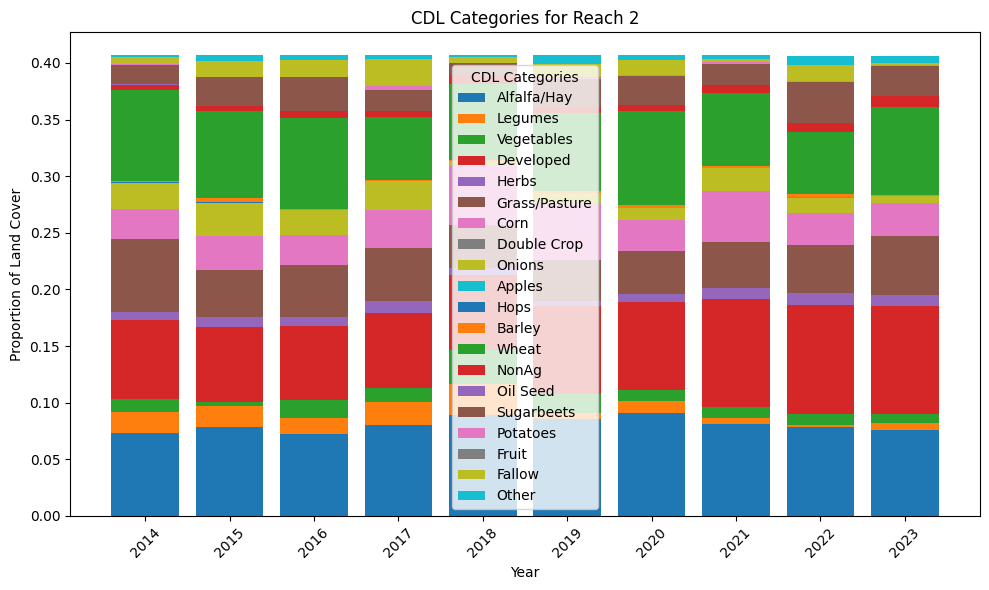

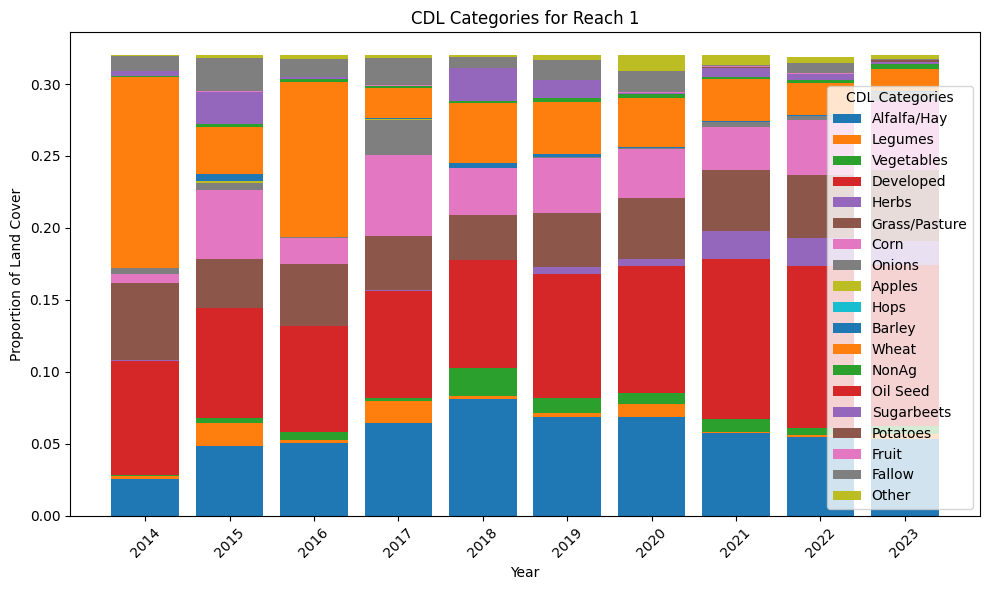

In [ ]:
# Path to the directory where the masked CDL files are saved
masked_cdl_dir = '/content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/'


# Initialize a dictionary to store CDL proportions for each reach
cdl_proportions = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

# Find all the masked CDL files in the directory
masked_cdl_files = glob.glob(os.path.join(masked_cdl_dir, '*.tif'))

# Loop through each masked CDL file
for cdl_file in masked_cdl_files:
    filename = os.path.basename(cdl_file)

    # Extract feature name and year from the filename
    feature_name, year = filename.replace('.tif', '').split('_')

    # Open the masked CDL file
    with rasterio.open(cdl_file) as dataset:
        # Read the data and calculate unique values and their counts
        data = dataset.read(1)
        unique, counts = np.unique(data, return_counts=True)
        total_pixels = counts.sum()

        # Calculate the proportion of each CDL category
        for u, count in zip(unique, counts):
            if u in cdl_categories:  # Only consider valid CDL categories
                cdl_proportions[feature_name][year][cdl_categories[u]] += count / total_pixels

# Convert defaultdict to a regular dictionary for easier plotting
cdl_proportions = {k: dict(v) for k, v in cdl_proportions.items()}

# Function to create a stacked bar plot for a given reach
def plot_stacked_bar(data, reach_name):
    years = list(map(str, range(2014, 2024)))  # Ensure years are strings for consistency

    # Identify the categories that are present (i.e., have non-zero values)
    present_categories = set()
    for year in years:
        for category, proportion in data.get(year, {}).items():
            if proportion > 0:
                present_categories.add(category)

    # Prepare data for plotting
    bottom = np.zeros(len(years))

    plt.figure(figsize=(10, 6))

    # Plot only the categories that are present
    for category in present_categories:
        values = [data.get(year, {}).get(category, 0) for year in years]
        if any(values):  # Only plot categories that have non-zero values
            plt.bar(years, values, bottom=bottom, label=category)
            bottom += values

    plt.title(f'CDL Categories for {reach_name}')
    plt.xlabel('Year')
    plt.ylabel('Proportion of Land Cover')
    plt.legend(title="CDL Categories")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot stacked bar chart for each reach
for reach_name, year_data in cdl_proportions.items():
    plot_stacked_bar(year_data, reach_name)
